In [17]:
import pandas as pd
from sklearn.neural_network import MLPClassifier
import glob
import numpy as np
import ast

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torchaudio.transforms import MelSpectrogram
from torchaudio.transforms import Resample
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

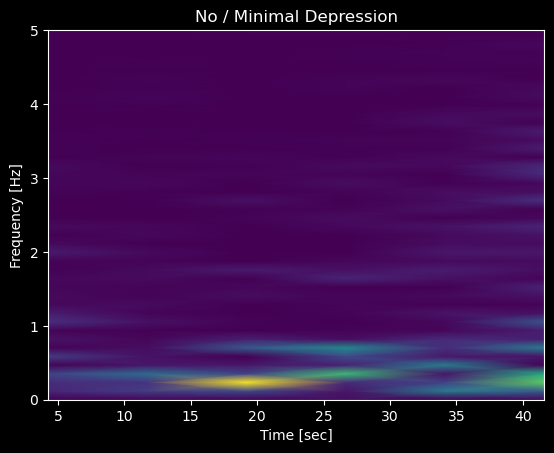

In [18]:
from scipy.signal import spectrogram
import matplotlib.pyplot as plt

plt.style.use('dark_background')
# plt.style.use('seaborn-v0_8')
plt.rcParams["grid.linestyle"] = "--"

# plt.rcParams["figure.figsize"] = (16, 5)

plt.rcParams['legend.frameon'] = True
plt.rcParams['legend.shadow'] = True
plt.rcParams['legend.facecolor'] = "darkslateblue"

# Assuming you have a DataFrame df with columns x_coord and y_coord
# Create spectrograms for x and y coordinates
def create_spectrogram(data):
    _, _, Sxx = spectrogram(data, fs=30)  # Assuming a sampling frequency of 100 Hz
    return torch.tensor(Sxx)

df = pd.read_csv('data/innovaid_hackathon_anima/input_coords_30/YCstEssT38mPc9moNvOo.csv')
f, t, Sxx = spectrogram(df["RX_coord_mean"], 30)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.title("No / Minimal Depression")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0, 5)
plt.show()

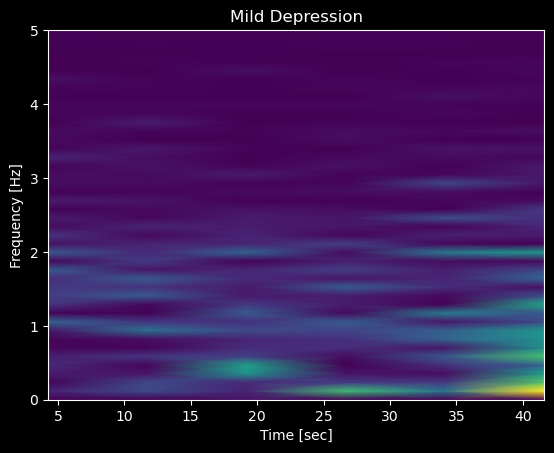

In [19]:
df = pd.read_csv('data/innovaid_hackathon_anima/input_coords_30/SKyBynt433ddTJgyz6fL.csv')
f, t, Sxx = spectrogram(df["RX_coord_mean"], 30)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.title("Mild Depression")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0, 5)
plt.show()

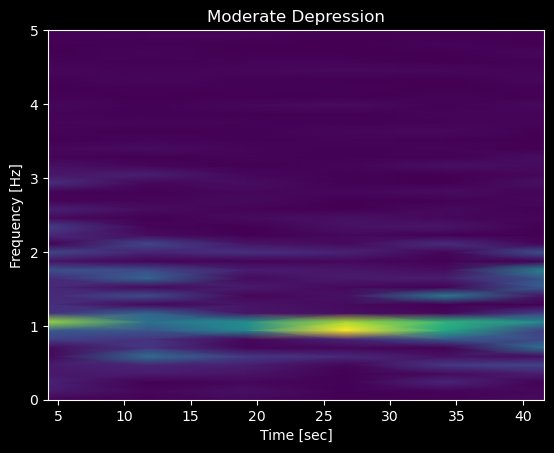

In [20]:
df = pd.read_csv('data/innovaid_hackathon_anima/input_coords_30/wKkEhydn8ndGZTO747zN.csv')
f, t, Sxx = spectrogram(df["RX_coord_mean"], 30)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.title("Moderate Depression")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0, 5)
plt.show()

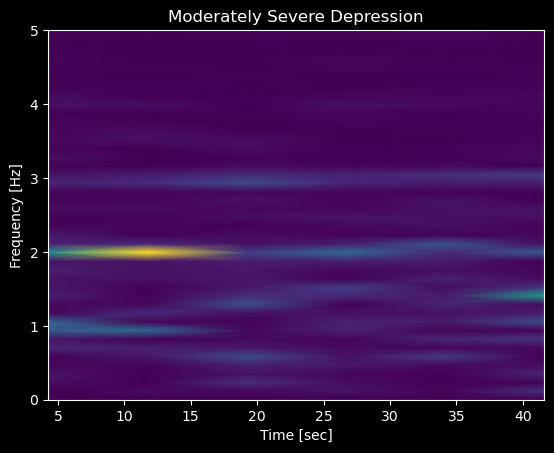

In [21]:
df = pd.read_csv('data/innovaid_hackathon_anima/input_coords_30/un0qLbEvxiEiLj6qVfiN.csv')
f, t, Sxx = spectrogram(df["RX_coord_mean"], 30)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.title("Moderately Severe Depression")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0, 5)
plt.show()

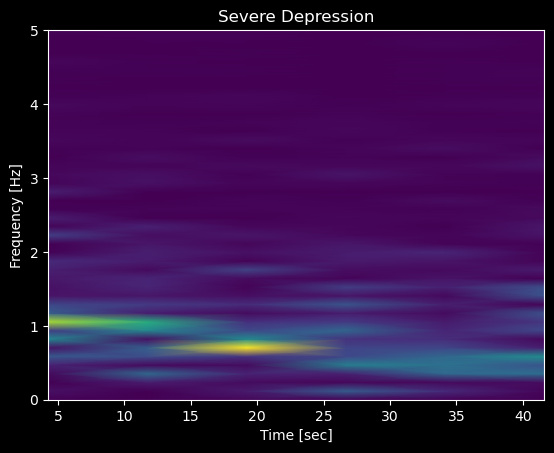

In [22]:
df = pd.read_csv('data/innovaid_hackathon_anima/input_coords_30/4I4xbX4fkH9RmqED2wpF.csv')
f, t, Sxx = spectrogram(df["RX_coord_mean"], 30)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.title("Severe Depression")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0, 5)
plt.show()

In [ ]:
from scipy.signal import spectrogram
import matplotlib.pyplot as plt

plt.style.use('dark_background')
# plt.style.use('seaborn-v0_8')
plt.rcParams["grid.linestyle"] = "--"

# plt.rcParams["figure.figsize"] = (16, 5)

plt.rcParams['legend.frameon'] = True
plt.rcParams['legend.shadow'] = True
plt.rcParams['legend.facecolor'] = "darkslateblue"

# Assuming you have a DataFrame df with columns x_coord and y_coord
# Create spectrograms for x and y coordinates
def create_spectrogram(data):
    _, _, Sxx = spectrogram(data, fs=30)  # Assuming a sampling frequency of 100 Hz
    return torch.tensor(Sxx)

df = pd.read_csv('data/innovaid_hackathon_anima/input_coords_30/aMnRrBJa9L14KZaSW6X6.csv')


f, t, Sxx = spectrogram(df["RX_coord_mean"], 30)

plt.pcolormesh(t, f, Sxx, shading='gouraud')

plt.ylabel('Frequency [Hz]')

plt.xlabel('Time [sec]')

plt.ylim(0, 8)

plt.show()

print(Sxx.shape)


In [386]:
import os
per_scene = 30

df_labels = pd.read_csv('data/innovaid_hackathon_anima/output_classes.csv')

X = []
y = []
files = glob.glob(f"data/innovaid_hackathon_anima/input_coords_{per_scene}/*.csv")
for file in files:
    df = pd.read_csv(file)
    if df.shape[0] != 50 * per_scene:
        continue
    df.fillna(0, inplace=True)
    df.drop("SCENE_INDEX", inplace=True, axis=1)
    x_spec = create_spectrogram(df["RX_coord_mean"])
    # y_spec = create_spectrogram(df["RY_coord_mean"])
    # Convert the data to PyTorch tensors
    X.append(x_spec)
    # X.append(torch.stack([x_spec, y_spec], axis=1))
    y.append(list(df_labels[df_labels['sid'] == file.split("/")[-1].split('.')[0]]['depression_severity'])[0])


(array([133., 487., 788., 878., 677.]),
 array([0., 1., 2., 3., 4., 5.]),
 <BarContainer object of 5 artists>)

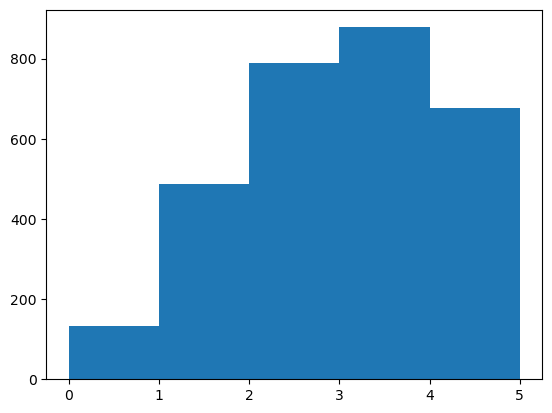

In [387]:
plt.hist(y, bins=np.arange(0, 6))

In [388]:
len(X), len(y)

(2963, 2963)

In [389]:
X[0].shape

torch.Size([129, 6])

In [390]:
X = np.array(X)
y = np.array(y)

In [391]:
y = (y + np.where(y == 0, y, -1) + 1) - 1

(array([620., 788., 878., 677.,   0.]),
 array([0., 1., 2., 3., 4., 5.]),
 <BarContainer object of 5 artists>)

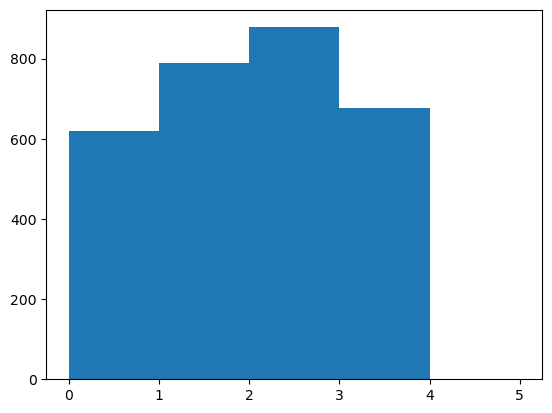

In [392]:
plt.hist(y, bins=np.arange(0, 6))

In [393]:
import numpy as np

def balance_dataset(X, y, m):
    unique_classes, class_counts = np.unique(y, return_counts=True)

    # Find the minimum count across all classes
    min_count = min(class_counts)

    # Initialize lists to store the trimmed data and labels
    X_trimmed = []
    y_trimmed = []

    for cls in unique_classes:
        # Indices of the current class
        indices = np.where(y == cls)[0]

        # Trim the indices to have exactly 'm' occurrences
        trimmed_indices = np.random.choice(indices, size=min(m, len(indices)), replace=False)

        # Append the trimmed data and labels
        X_trimmed.append(X[trimmed_indices])
        y_trimmed.append(y[trimmed_indices])

    # Concatenate the trimmed data and labels
    X_trimmed = np.concatenate(X_trimmed)
    y_trimmed = np.concatenate(y_trimmed)

    return X_trimmed, y_trimmed


In [394]:
X, y = balance_dataset(X, y, 600)

(array([600., 600., 600., 600.,   0.]),
 array([0., 1., 2., 3., 4., 5.]),
 <BarContainer object of 5 artists>)

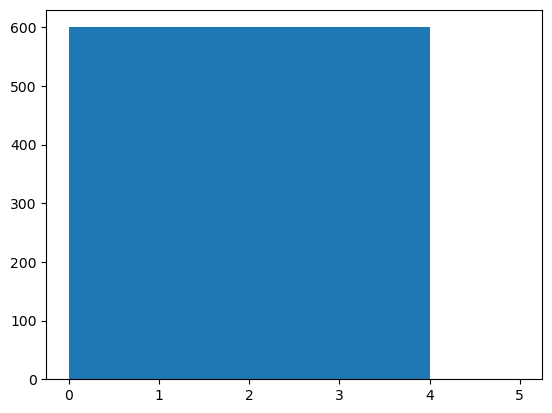

In [395]:
plt.hist(y, bins=np.arange(0, 6))

In [396]:
X = torch.DoubleTensor(X).reshape(-1, 129, 6).float()
y = torch.IntTensor(y)

print(X.shape, y.shape)

torch.Size([2400, 129, 6]) torch.Size([2400])


In [397]:
# y_hot = torch.nn.functional.one_hot(y.to(torch.int64), num_classes=4).to(torch.float32)
# y = y_hot

In [398]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset
# import numpy as np
#
# from torch.utils.data import DataLoader, TensorDataset
# from sklearn.model_selection import train_test_split
#
# # Assuming you have your X and y data
# # X shape: [samples, 129, 6]
# # y shape: [samples]
#
# # Hyperparameters
# batch_size = 32
# learning_rate = 0.001
# num_epochs = 10
#
# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#
# train_dataset = TensorDataset(X_train, y_train)
# test_dataset = TensorDataset(X_test, y_test)
#
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
#
#
#
# # Define the CNN model
# class SimpleCNN(nn.Module):
#     def __init__(self):
#         super(SimpleCNN, self).__init__()
#         self.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 6), stride=1, padding=(1, 0))
#         self.relu = nn.ReLU()
#         self.pool = nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1))
#         self.conv2 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=1, padding=1)
#         self.flatten = nn.Flatten()
#         self.fc1 = nn.Linear(32 * 32, 128)
#         self.fc2 = nn.Linear(128, 4)  # 5 classes
#
#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.relu(x)
#         x = self.pool(x)
#         x = self.conv2(x)
#         x = self.relu(x)
#         x = self.pool(x)
#         x = self.flatten(x)
#         x = self.fc1(x)
#         x = self.relu(x)
#         x = self.fc2(x)
#         return x
#
# # Instantiate the model, loss function, and optimizer
# model = SimpleCNN()
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#
# # Training loop
# model.train()
# for epoch in range(num_epochs):
#     for inputs, labels in train_dataloader:
#         inputs = inputs.reshape(-1, 1, 129, 6)
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#
#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
#
#     correct = 0
#     total = 0
#     # since we're not training, we don't need to calculate the gradients for our outputs
#     with torch.no_grad():
#         for data in test_dataloader:
#             images, labels = data
#             images = images.reshape(-1, 1, 129, 6)
#             # calculate outputs by running images through the network
#             outputs = model(images)
#             # the class with the highest energy is what we choose as prediction
#             _, predicted = torch.max(outputs, 1)
#             l = torch.argmax(labels, dim=1)
#             total += labels.size(0)
#             print(predicted)
#             correct += (predicted == l).sum().item()
#
#     print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')
#


In [399]:
X = X.reshape(-1, 129 * 6)

In [400]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [401]:
# from sklearn.svm import SVC
#
# model = SVC(random_state=42)
# model.fit(X_train, y_train)

In [402]:
# model.score(X_test, y_test)
